In [429]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### List of model to test:
* Random Forest
* XGBoost 
* Catboost
* MLP

## I. Data processing

In [425]:
train_and_val = pd.read_excel('/Users/trongphan/Downloads/Rice_Datathon/rice-datathon-2025/data/training.xlsx')

In [426]:
train_and_val["Vehicle Age"] = train_and_val["Date"] - train_and_val["Model Year"]

In [427]:
train_and_val.columns

Index(['Date', 'Vehicle Category', 'GVWR Class', 'Fuel Type', 'Model Year',
       'Fuel Technology', 'Electric Mile Range',
       'Number of Vehicles Registered at the Same Address', 'Region',
       'Vehicle Population', 'Vehicle Age'],
      dtype='object')

In [428]:
train_and_val.to_csv('/Users/trongphan/Downloads/Rice_Datathon/rice-datathon-2025/data/train_and_val.csv', index=False)

In [378]:
def summarize_df(df, max_columns=10):
    summary = {
        'shape': df.shape,
        'columns': df.columns.tolist()[:max_columns] + ['...'] if len(df.columns) > max_columns else df.columns.tolist(),
        'missing_values': {col: df.isnull().sum()[col] for col in df.columns[:max_columns]} if len(df.columns) > max_columns else df.isnull().sum().to_dict(),
        'describe': df.describe(include='all').iloc[:, :max_columns].to_dict() if len(df.columns) > max_columns else df.describe(include='all').to_dict(),
        'num_columns': len(df.columns),
        'distinct_values': {col: df[col].nunique() for col in df.columns[:max_columns]} if len(df.columns) > max_columns else {col: df[col].nunique() for col in df.columns},
        'columns_with_few_distinct_values': {col: df[col].unique().tolist() for col in df.columns[:max_columns] if df[col].nunique() < 20} if len(df.columns) > max_columns else {col: df[col].unique().tolist() for col in df.columns if df[col].nunique() < 20}
    }
    return summary


In [379]:
import json
summary = summarize_df(train_and_val)

with open('summary.json', 'w') as f:
    json.dump(summary, f, indent=4)

In [380]:
# Data processing

# Convert 'Date' to datetime format and extract the year
train_and_val['Date'] = pd.to_datetime(train_and_val['Date'], format='%Y').dt.year

# Fill missing values in 'Model Year' with the median value
train_and_val['Model Year'].fillna(train_and_val['Model Year'].median(), inplace=True)

# Convert 'Model Year' to integer
train_and_val['Model Year'] = train_and_val['Model Year'].astype(int)

# Convert categorical columns to category dtype
categorical_columns = ['Vehicle Category', 'GVWR Class', 'Fuel Type', 'Fuel Technology', 'Electric Mile Range', 'Number of Vehicles Registered at the Same Address', 'Model Year']
for col in categorical_columns:
    train_and_val[col] = train_and_val[col].astype('category')

# Remove duplicates
train_and_val.drop_duplicates(inplace=True)

# Reset index
train_and_val.reset_index(drop=True, inplace=True)

# Display the cleaned dataframe
train_and_val = train_and_val.drop(columns=["Region"])

In [381]:
# Load data (replace with your actual dataset)
data = train_and_val
# Preprocessing
# One-hot encode categorical columns
categorical_cols = ["Vehicle Category", "Fuel Type", "Fuel Technology", "Electric Mile Range"]
data = pd.get_dummies(data, columns=categorical_cols)

In [382]:
# Ordinal encode "Number of Vehicles Registered at the Same Address"
ordinal_mapping = {1: int(1), 2: int(2), 3: int(3), "\u22654": 4, "Unknown": -1}
data["Number of Vehicles Registered at the Same Address"] = data["Number of Vehicles Registered at the Same Address"].map(ordinal_mapping)

In [383]:
# Preprocessing
# Impute missing values in "Model Year"
imputer = SimpleImputer(strategy="median")
data["Model Year"] = imputer.fit_transform(data[["Model Year"]])
# Handle non-numeric values in "GVWR Class"
# For this GVWR, we find that online but decided to not replace it with any value since we still treat it as categorical
data["GVWR Class"] = data["GVWR Class"].replace({"Not Applicable": -1, "Unknown": -1})

In [384]:
# Feature engineering
data["Vehicle Age"] = data["Date"] - data["Model Year"]

In [423]:
data

,Date,GVWR Class,Model Year,Number of Vehicles Registered at the Same Address,Vehicle Population,Vehicle Category_B,Vehicle Category_BS,Vehicle Category_BT,Vehicle Category_MC,Vehicle Category_MH,...,Fuel Technology_FCEV,Fuel Technology_ICE,Fuel Technology_PHEV,Electric Mile Range_0 to 50 miles,Electric Mile Range_101 to 150 miles,Electric Mile Range_51 to 100 miles,Electric Mile Range_>150 miles,Electric Mile Range_Not Applicable,Electric Mile Range_Unknown,Vehicle Age
0,2019,-1,2020.0,4,395883,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,-1.0
1,2020,-1,2020.0,1,370954,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0.0
2,2021,-1,2020.0,1,349406,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1.0
3,2019,-1,2019.0,4,348475,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0.0
4,2019,-1,2018.0,4,333296,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41035,2019,-1,1983.0,1,1,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,36.0
41036,2019,-1,1980.0,2,1,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,39.0
41037,2019,-1,1978.0,3,1,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,41.0
41038,2019,-1,1976.0,2,1,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,43.0


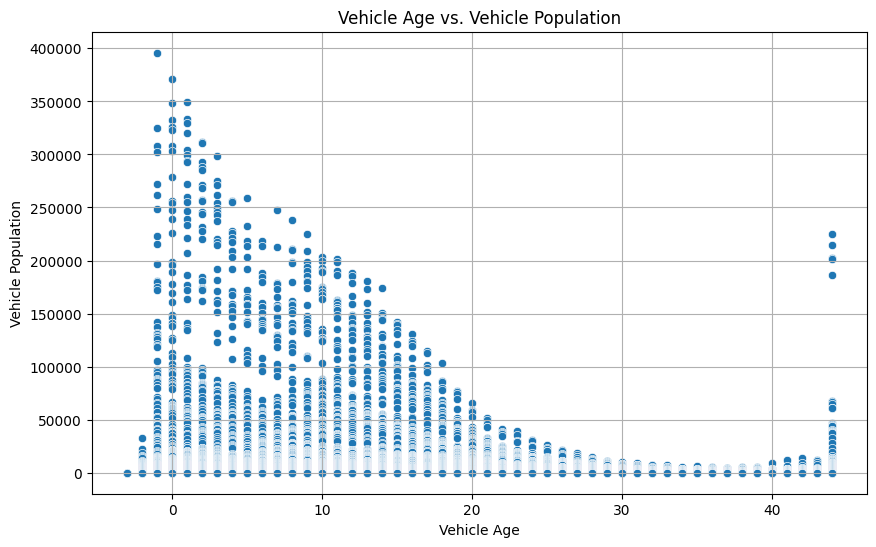

In [385]:
# Plot the new feature "Vehicle Age" and "Vehicle Population"
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.scatterplot(x="Vehicle Age", y="Vehicle Population", data=data)
plt.title("Vehicle Age vs. Vehicle Population")
plt.xlabel("Vehicle Age")
plt.ylabel("Vehicle Population")
plt.grid(True)
plt.show()

In [386]:
# Check for missing values in the dataset
print("Missing values in each column:")
print(data.isnull().sum())

# Handle missing values in all columns
for col in data.columns:
    if data[col].dtype == "object" or pd.api.types.is_categorical_dtype(data[col]):  # Categorical columns
        data[col].fillna(data[col].mode()[0], inplace=True)
    else:  # Numerical columns
        data[col].fillna(data[col].median(), inplace=True)

Missing values in each column:
Date                                                 0
GVWR Class                                           0
Model Year                                           0
Number of Vehicles Registered at the Same Address    0
Vehicle Population                                   0
Vehicle Category_B                                   0
Vehicle Category_BS                                  0
Vehicle Category_BT                                  0
Vehicle Category_MC                                  0
Vehicle Category_MH                                  0
Vehicle Category_P                                   0
Vehicle Category_T1                                  0
Vehicle Category_T2                                  0
Vehicle Category_T3                                  0
Vehicle Category_T4                                  0
Vehicle Category_T5                                  0
Vehicle Category_T6                                  0
Vehicle Category_T7               

In [387]:
# Split data
X = data.drop(columns=["Vehicle Population"])
y = data["Vehicle Population"]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

### III. Testset
#### 3. Build test set

In [388]:
df_test = pd.read_excel('/Users/trongphan/Downloads/Rice_Datathon/rice-datathon-2025/data/scoring & submission format.xlsx')
test_data = df_test

# Convert 'Date' to datetime format and extract the year
test_data['Date'] = pd.to_datetime(test_data['Date'], format='%Y').dt.year
# Fill missing values in 'Model Year' with the median value
test_data['Model Year'].fillna(test_data['Model Year'].median(), inplace=True)
# Convert 'Model Year' to integer
test_data['Model Year'] = test_data['Model Year'].astype(int)

# Convert categorical columns to category dtype
categorical_columns = ['Vehicle Category', 'GVWR Class', 'Fuel Type', 'Fuel Technology', 'Electric Mile Range', 'Number of Vehicles Registered at the Same Address', 'Region']
for col in categorical_columns:
    test_data[col] = test_data[col].astype('category')
# One-hot encode categorical columns
categorical_cols = ["Vehicle Category", "Fuel Type", "Fuel Technology", "Electric Mile Range"]
test_data = pd.get_dummies(df_test, columns=categorical_cols)
# Display the cleaned dataframe
test_data = test_data.drop(columns=["Region"])
# Remove duplicates
# test_data.drop_duplicates(inplace=True)
# Reset index
test_data.reset_index(drop=True, inplace=True)
test_data
# Ordinal encode "Number of Vehicles Registered at the Same Address"
ordinal_mapping = {1: int(1), 2: int(2), 3: int(3), "\u22654": 4, "Unknown": -1}
test_data["Number of Vehicles Registered at the Same Address"] = test_data["Number of Vehicles Registered at the Same Address"].map(ordinal_mapping)

# Preprocessing
# Impute missing values in "Model Year"
imputer = SimpleImputer(strategy="median")
test_data["Model Year"] = imputer.fit_transform(test_data[["Model Year"]])
# Handle non-numeric values in "GVWR Class"
test_data["GVWR Class"] = test_data["GVWR Class"].replace({"Not Applicable": -1, "Unknown": -1})

# # Feature engineering
test_data["Vehicle Age"] = test_data["Date"] - test_data["Model Year"]

# Check for missing values in the test_dataset
print("Missing values in each column:")
print(test_data.isnull().sum())
# Handle missing values in all columns
for col in test_data.columns:
    if test_data[col].dtype == "object" or pd.api.types.is_categorical_dtype(test_data[col]):  # Categorical columns
        test_data[col].fillna(test_data[col].mode()[0], inplace=True)
    else:  # Numerical columns
        test_data[col].fillna(test_data[col].median(), inplace=True)

# Split test_data
X_test = test_data.drop(columns=["Vehicle Population"])
y_test = test_data["Vehicle Population"]

"""
Handle missing columns of X_test, which is Fuel Type_Unknown
"""

# Find the index of 'Fuel Type_Natural Gas'
insert_index = X_test.columns.get_loc('Fuel Type_Natural Gas') + 1

# Insert 'Fuel Type_Unknown' after 'Fuel Type_Natural Gas' and fill with 0
X_test.insert(insert_index, 'Fuel Type_Unknown', 0)

# Now X_test has the 'Fuel Type_Unknown' column after 'Fuel Type_Natural Gas'
print(X_test.columns)
X_test

Missing values in each column:
Date                                                 0
GVWR Class                                           0
Model Year                                           0
Number of Vehicles Registered at the Same Address    0
Vehicle Population                                   0
Vehicle Category_B                                   0
Vehicle Category_BS                                  0
Vehicle Category_BT                                  0
Vehicle Category_MC                                  0
Vehicle Category_MH                                  0
Vehicle Category_P                                   0
Vehicle Category_T1                                  0
Vehicle Category_T2                                  0
Vehicle Category_T3                                  0
Vehicle Category_T4                                  0
Vehicle Category_T5                                  0
Vehicle Category_T6                                  0
Vehicle Category_T7               

,Date,GVWR Class,Model Year,Number of Vehicles Registered at the Same Address,Vehicle Category_B,Vehicle Category_BS,Vehicle Category_BT,Vehicle Category_MC,Vehicle Category_MH,Vehicle Category_P,...,Fuel Technology_FCEV,Fuel Technology_ICE,Fuel Technology_PHEV,Electric Mile Range_0 to 50 miles,Electric Mile Range_101 to 150 miles,Electric Mile Range_51 to 100 miles,Electric Mile Range_>150 miles,Electric Mile Range_Not Applicable,Electric Mile Range_Unknown,Vehicle Age
0,2024,-1,2020.0,4,0,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,4.0
1,2024,-1,2021.0,4,0,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,3.0
2,2024,-1,2022.0,4,0,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,2.0
3,2024,-1,2024.0,4,0,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0.0
4,2024,-1,2023.0,4,0,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7541,2024,-1,1989.0,3,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,35.0
7542,2024,-1,1988.0,2,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,36.0
7543,2024,-1,1988.0,3,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,36.0
7544,2024,-1,1987.0,2,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,37.0


## II. Random Forest

#### 2. Train Vanilla Random Forest

In [431]:
# Train Random Forest model

random_forest_model = RandomForestRegressor(random_state=28)
random_forest_model.fit(X_train, y_train)

RandomForestRegressor(random_state=28)

In [432]:
from sklearn.utils import shuffle
import math 
# Shuffle X_test and y_test
X_test, y_test = shuffle(X_test, y_test, random_state=42)

# Evaluate
y_pred_val = random_forest_model.predict(X_val)
print("VALIDATION SET")
print("Mean Absolute Error (MAE):", mean_absolute_error(y_val, y_pred_val))
print("Root Mean Squared Error (RMSE):", math.sqrt(mean_squared_error(y_val, y_pred_val)))
print("R-squared (R2):", r2_score(y_val, y_pred_val))

print("*" * 50)
y_pred = random_forest_model.predict(X_test)
print("TEST SET")
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE):", math.sqrt(mean_squared_error(y_test, y_pred)))
print("R-squared (R2):", r2_score(y_test, y_pred))

# Create a DataFrame with y_val and y_pred
results_df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
print(results_df)

VALIDATION SET
Mean Absolute Error (MAE): 399.37247792803765
Root Mean Squared Error (RMSE): 2671.9736507637435
R-squared (R2): 0.979362055053613
**************************************************
TEST SET
Mean Absolute Error (MAE): 559.8596781123396
Root Mean Squared Error (RMSE): 3730.6078947661886
R-squared (R2): 0.9632728905322289
      y_test   y_pred
7238       1     2.28
3434      58    83.85
740     3425  3426.17
2875     112   142.89
554     5771  6087.88
...      ...      ...
6062       3     2.12
5981       3     3.39
1394     853  1032.91
1726     495   480.70
3255      70    79.69

[7546 rows x 2 columns]


#### 4. Parameter tuning

##### a. Using GridSearchCV

In [225]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm
import time

In [226]:
# Define the parameter grid
param_grid = {
    "n_estimators": [50, 100, 200],  # Number of trees
    "max_depth": [None, 10, 20, 30],  # Maximum depth of trees
    "min_samples_split": [2, 5, 10],  # Minimum samples to split a node
    "min_samples_leaf": [1, 2, 4],  # Minimum samples at a leaf node
    "max_features": ["sqrt", "log2"],  # Number of features to consider for splits
    "bootstrap": [True, False]  # Whether to use bootstrap sampling
}

# Initialize the Random Forest model
rf = RandomForestRegressor(random_state=42)

In [ ]:
# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring="neg_mean_squared_error",  # Use RMSE as the evaluation metric
    n_jobs=-1,  # Use all available CPU cores
    verbose=3  # Disable default verbose output
)

# Track time using tqdm
start_time = time.time()
with tqdm(total=len(grid_search.param_grid) * 5, desc="Grid Search Progress") as pbar:
    # Attach the callback to GridSearchCV
    grid_search.fit(X_train, y_train)

In [ ]:
"""
Best Parameters: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best R-squared Score: -14547067.220303629
Model 1:
Score: -14547067.220303629
RMSE on test set: 4167.32
"""

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best R-squared Score:", grid_search.best_score_)

# Evaluate on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Test R-squared:", r2_score(y_test, y_pred))

##### 2. Random state

In [181]:
# param = {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}

# Initialize the Random Forest model with the specified parameters
list_rmse = []
min_rmse = 99999999
for i in tqdm(range(1, 100)):
    rf = RandomForestRegressor(random_state=i)

    # Fit the model to the training data
    rf.fit(X_train, y_train)

    # Predict on the validation set
    y_pred = rf.predict(X_test)
    rmse_now = math.sqrt(mean_squared_error(y_test, y_pred))
    if rmse_now < min_rmse:
        min_rmse = rmse_now
        print(f"GET NEW MIN RMSE: {min_rmse} at state {i}")
    list_rmse.append({"state": i, "rmse": rmse_now})
    
top_5_rmse = sorted(list_rmse, key=lambda x: x['rmse'])[:5]
for top_rmse in top_5_rmse:
    print("State:", top_rmse['state'])
    print("Mean Squared Error (MSE):", top_rmse['rmse'])

    # # Create a DataFrame with y_test and y_pred
    # results_df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
    # print(results_df)

  1%|          | 1/99 [00:18<30:45, 18.83s/it]

GET NEW MIN RMSE: 3819.0698253265646 at state 1


  2%|▏         | 2/99 [00:32<25:13, 15.60s/it]

GET NEW MIN RMSE: 3797.658412485756 at state 2


  4%|▍         | 4/99 [00:56<20:51, 13.18s/it]

GET NEW MIN RMSE: 3771.4759583661867 at state 4


 12%|█▏        | 12/99 [02:56<19:37, 13.53s/it]

GET NEW MIN RMSE: 3761.9088017471486 at state 12


 28%|██▊       | 28/99 [06:13<14:55, 12.62s/it]

GET NEW MIN RMSE: 3730.855110411834 at state 28


100%|██████████| 99/99 [19:23<00:00, 11.75s/it]

State: 28
Mean Squared Error (MSE): 3730.855110411834
State: 86
Mean Squared Error (MSE): 3758.1965286714612
State: 12
Mean Squared Error (MSE): 3761.9088017471486
State: 4
Mean Squared Error (MSE): 3771.4759583661867
State: 21
Mean Squared Error (MSE): 3774.779295305305


##### Random Search (to save time)

<!-- #### b. Using Randomized GridSearch -->

In [146]:
from sklearn.model_selection import RandomizedSearchCV

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=50,  # Number of parameter combinations to try
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=3,
    random_state=42
)

# Fit the RandomizedSearchCV
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50;, score=-83638092.122 total time=   1.6s
[CV 2/5] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50;, score=-61070439.728 total time=   1.7s
[CV 3/5] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50;, score=-80383072.450 total time=   1.8s
[CV 4/5] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50;, score=-103738001.292 total time=   2.2s
[CV 5/5] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50;, score=-53056551.020 total time=   2.2s
[CV 1/5] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50;, score=-46314651.

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=3)

In [147]:
# Print the best parameters and best score
print("Best Parameters:", random_search.best_params_)
print("Best RMSE:", math.sqrt(-random_search.best_score_))

Best Parameters: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'bootstrap': False}
Best RMSE: 3815.4722499374857


In [148]:
y_pred_random = random_search.predict(X_test)
rmse = math.sqrt(mean_squared_error(y_test, y_pred_random))
print("Test RMSE:", rmse)

Test RMSE: 4177.8294461009555


## Test with Full data

In [343]:
X_train_full = X
y_train_full = y

In [344]:
# Train Random Forest model
param = {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
# model = RandomForestRegressor(random_state=42, **param)
random_forest_model_full = RandomForestRegressor(random_state=28)
# model.fit(X_train_full, y_train_full)
random_forest_model_full.fit(X_train_full, y_train_full)

RandomForestRegressor(random_state=28)

In [345]:
from sklearn.utils import shuffle
import math 
# Shuffle X_test and y_test
X_test, y_test = shuffle(X_test, y_test, random_state=42)

# Evaluate
print("*" * 50)
y_pred_full = random_forest_model_full.predict(X_test)
print("TEST SET")
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_pred_full))
print("Root Mean Squared Error (RMSE):", math.sqrt(mean_squared_error(y_test, y_pred_full)))
print("R-squared (R2):", r2_score(y_test, y_pred_full))

# Create a DataFrame with y_val and y_pred_full
results_df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred_full})
print(results_df)

**************************************************
TEST SET
Mean Absolute Error (MAE): 519.6756179117288
Root Mean Squared Error (RMSE): 3798.58794191661
R-squared (R2): 0.9619221945923139
      y_test   y_pred
1843     411   862.19
7432       1     1.73
1886     384   427.49
6886       1     2.67
2957      98    12.03
...      ...      ...
943     2158  2189.04
454     8812  8945.34
2252     246   353.10
4958       9     6.23
1907     374     1.18

[7546 rows x 2 columns]


## IV. New models

### 1. CatBoost only

In [389]:
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Define the parameter grid
param_grid = {
    "iterations": [500, 1000, 1500],  # Number of trees
    "learning_rate": [0.01, 0.05, 0.1],  # Step size shrinkage
    "depth": [4, 6, 8],  # Depth of the trees
    "l2_leaf_reg": [1, 3, 5],  # L2 regularization
    "random_strength": [0.1, 0.5, 1],  # Randomness for scoring splits
    "bagging_temperature": [0, 0.5, 1],  # Controls Bayesian bagging
    "border_count": [32, 64, 128],  # Number of splits for numerical features
    "verbose": [False]  # Disable verbose output during grid search
}

In [419]:
X_train_cat = X_train_full.copy()
X_test_cat = X_test.copy()
# Define categorical columns
categorical_cols = list(X_train_cat.columns)
# Convert all columns to string
X_train_cat[categorical_cols] = X_train_cat[categorical_cols].astype(str)
X_test_cat[categorical_cols] = X_test_cat[categorical_cols].astype(str)
y_test_cat = y_test.copy()


In [421]:
best_params_catboost = {'verbose': False, 'random_strength': 0.5, 'learning_rate': 0.1, 'l2_leaf_reg': 1, 'iterations': 1000, 'depth': 8, 'border_count': 32, 'bagging_temperature': 1}
# best_params_catboost = {"bagging_temperature":0.5, "border_count":32, "depth":8, "iterations":1000, "l2_leaf_reg":3, "learning_rate":0.1, "random_strength":0.1, "verbose":False}
# Train the model with the best parameters
best_catboost_model = CatBoostRegressor(
    **best_params_catboost,
    random_state = 42
    # verbose=3  # Enable verbose output for training
)

best_catboost_model.fit(X_train_cat, y_train_full, cat_features=categorical_cols)

In [422]:
import math 
from sklearn.utils import shuffle

# Shuffle X_test and y_test
# X_test_cat, y_test_cat = shuffle(X_test_cat, y_test, random_state=42)
# Predictions
catboost_preds = best_catboost_model.predict(X_test_cat)
catboost_rmse = np.sqrt(mean_squared_error(y_test_cat, catboost_preds))

# Evaluate
from sklearn.metrics import mean_squared_error
print(f"CatBoost RMSE: {catboost_rmse}")
print("*" * 50)
print("TEST SET")
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test_cat, catboost_preds))
print("Root Mean Squared Error (RMSE):", math.sqrt(mean_squared_error(y_test_cat, catboost_preds)))
print("R-squared (R2):", r2_score(y_test_cat, catboost_preds))

# Create a DataFrame with y_val and y_test_pred_catboost
results_df = pd.DataFrame({'y_test': y_test_cat, 'y_pred': catboost_preds})
print(results_df)

CatBoost RMSE: 5661.892980246868
**************************************************
TEST SET
Mean Absolute Error (MAE): 2092.9836325626648
Root Mean Squared Error (RMSE): 5661.892980246868
R-squared (R2): 0.915403800664447
      y_test         y_pred
3612      47   -1523.394424
393    11999    4759.198442
6997       1    3439.385699
5216       7     195.638527
23    183742  165083.701332
...      ...            ...
5191       7   -2978.960006
5226       7   -1004.149842
5390       6    -167.965892
860     2551    -394.536591
7270       1     644.065323

[7546 rows x 2 columns]


### 2. LightGBM

In [137]:
# Convert categorical columns to 'category' dtype
X_train_lgb = X_train.copy()
X_test_lgb = X_test.copy()
categorical_cols = X_train_lgb.select_dtypes(include=['object']).columns
for col in categorical_cols:
    X_train_lgb[col] = X_train_lgb[col].astype('category')
    X_test_lgb[col] = X_test_lgb[col].astype('category')

# Get the indices of categorical columns
categorical_indices = [X_train_lgb.columns.get_loc(col) for col in categorical_cols]

# Create LightGBM datasets with categorical features
lgb_train = lgb.Dataset(X_train_lgb, label=y_train, categorical_feature=categorical_indices)
lgb_test = lgb.Dataset(X_test_lgb, label=y_test, categorical_feature=categorical_indices, reference=lgb_train)

In [130]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np

# Define the parameter grid
param_grid = {
    "objective": ["regression"],
    "metric": ["rmse"],
    "boosting_type": ["gbdt", "dart"],
    "num_leaves": [31, 50, 100],
    "learning_rate": [0.01, 0.05, 0.1],
    "feature_fraction": [0.8, 0.9, 1.0],
    "bagging_fraction": [0.8, 0.9, 1.0],
    "bagging_freq": [0, 5, 10],
    "min_data_in_leaf": [20, 50, 100],
    "lambda_l1": [0, 0.1, 0.5],
    "lambda_l2": [0, 0.1, 0.5],
    "random_state": [28],
    "shrinkage_rate": [0.01, 0.012, 0.015]
}

# Create the LightGBM regressor
lgb_model = LGBMRegressor()

# RandomizedSearchCV
random_search_lgb = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_grid,
    n_iter=50,  # Number of parameter settings to sample
    scoring='neg_root_mean_squared_error',  # Use RMSE as the scoring metric
    cv=5,  # 5-fold cross-validation
    verbose=1,
    random_state=28,
    n_jobs=-1  # Use all available cores
)

# Fit the model
random_search_lgb.fit(X_train, y_train)

# Best parameters
best_params_lgb = random_search_lgb.best_params_
print("Best Parameters:", best_params_lgb)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] learning_rate is set=0.05, shrinkage_rate=0.01 will be ignored. Current value: learning_rate=0.05
[LightGBM] [Warning] lambda_l2 is

In [135]:
best_params_lgb

{'shrinkage_rate': 0.01,
 'random_state': 28,
 'objective': 'regression',
 'num_leaves': 100,
 'min_data_in_leaf': 20,
 'metric': 'rmse',
 'learning_rate': 0.1,
 'lambda_l2': 0,
 'lambda_l1': 0,
 'feature_fraction': 0.8,
 'boosting_type': 'gbdt',
 'bagging_freq': 0,
 'bagging_fraction': 0.8}

In [138]:
# Train the model with the best parameters
lgb_model_best = LGBMRegressor(**best_params_lgb)
lgb_model_best.fit(X_train_lgb, y_train)

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] learning_rate is set=0.1, shrinkage_rate=0.01 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lamb

LGBMRegressor(bagging_fraction=0.8, bagging_freq=0, feature_fraction=0.8,
              lambda_l1=0, lambda_l2=0, metric='rmse', min_data_in_leaf=20,
              num_leaves=100, objective='regression', random_state=28,
              shrinkage_rate=0.01)

In [139]:
import math 
from sklearn.utils import shuffle
# Shuffle X_test and y_test
X_test, y_test = shuffle(X_test, y_test, random_state=42)

print("*" * 50)
y_test_pred_lgb = lgb_model_best.predict(X_test)
print("TEST SET")
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, y_test_pred_lgb))
print("Root Mean Squared Error (RMSE):", math.sqrt(mean_squared_error(y_test, y_test_pred_lgb)))
print("R-squared (R2):", r2_score(y_test, y_test_pred_lgb))

# Create a DataFrame with y_val and y_test_pred_lgb
results_df = pd.DataFrame({'y_test': y_test, 'y_pred': y_test_pred_lgb})
print(results_df)

**************************************************
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] learning_rate is set=0.1, shrinkage_rate=0.01 will be ignored. Current value: learning_rate=0.1
TEST SET
Mean Absolute Error (MAE): 12803.182732725518
Root Mean Squared Error (RMSE): 24216.38850495135
R-squared (R2): -0.5473583595655669
      y_test        y

### 3. Stacking RF + CatBoost

#### a. Use LR as a correlation mechanism

**************************************************
TEST SET
Mean Absolute Error (MAE): 564.6625111875599
Root Mean Squared Error (RMSE): 3757.968267481075
R-squared (R2): 0.9627321999564763
      y_test         y_pred
0     316065  292402.106986
1     315986  297319.851304
2     306487  292453.535178
3     284754  266745.410765
4     284153  280101.620602
...      ...            ...
7541       1     -11.022615
7542       1      -9.425686
7543       1     -10.489361
7544       1      -8.598244
7545       1      -9.767077

[7546 rows x 2 columns]


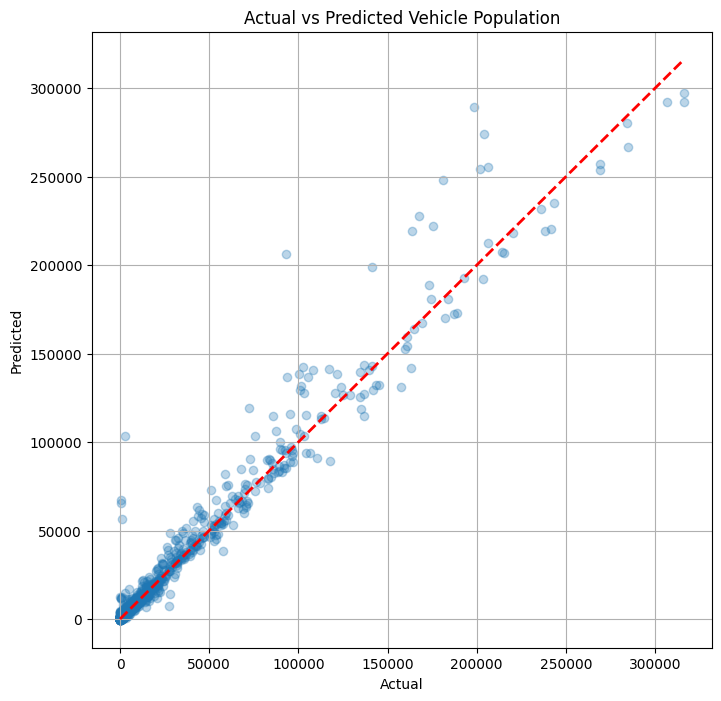

In [411]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Step 1: Train all models (assuming you already have trained models)
rf_preds = random_forest_model.predict(X_train)
cb_preds = best_catboost_model.predict(X_train_cat)

# Step 2: Create a new dataset using model predictions as features
stacked_features_1 = np.column_stack((rf_preds, cb_preds))

# Step 3: Train the meta-model (using RF predictions as the main guidance)
meta_model = LinearRegression()
meta_model.fit(stacked_features_1, y_train)

# Step 4: Predict using the meta-model
rf_preds_test = random_forest_model.predict(X_test)
cb_preds_test = best_catboost_model.predict(X_test_cat)
stacked_features_1_test = np.column_stack((rf_preds_test, cb_preds_test))
stacked_preds_1_test = meta_model.predict(stacked_features_1_test)

# Step 5: Ensure non-negative predictions (since vehicle population can't be negative)
stacked_preds_1 = np.maximum(stacked_preds_1_test, 0)

# Step 6: Evaluate performance
print("*" * 50)
rmse_stacked = np.sqrt(mean_squared_error(y_test, stacked_preds_1_test))
print("TEST SET")
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, stacked_preds_1_test))
print("Root Mean Squared Error (RMSE):", rmse_stacked)
print("R-squared (R2):", r2_score(y_test, stacked_preds_1_test))

# Step 5: Show predictions
results_df = pd.DataFrame({'y_test': y_test, 'y_pred': stacked_preds_1_test})
print(results_df)
# Plot the actual vs predicted values
plt.figure(figsize=(8, 8))
plt.scatter(y_test, stacked_preds_1_test, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Vehicle Population')
plt.grid(True)
plt.show()


### 2. Assign weights

**************************************************
TEST SET (Weighted Averaging)
Mean Absolute Error (MAE): 610.6528838432222
Root Mean Squared Error (RMSE): 3716.1873679627347
R-squared (R2): 0.9635562763288067
      y_test         y_pred
0     316065  287204.951537
1     315986  284955.877752
2     306487  290952.388361
3     284754  263151.741688
4     284153  278619.037024
...      ...            ...
7541       1       0.000000
7542       1       0.000000
7543       1       0.000000
7544       1       0.000000
7545       1       0.000000

[7546 rows x 2 columns]


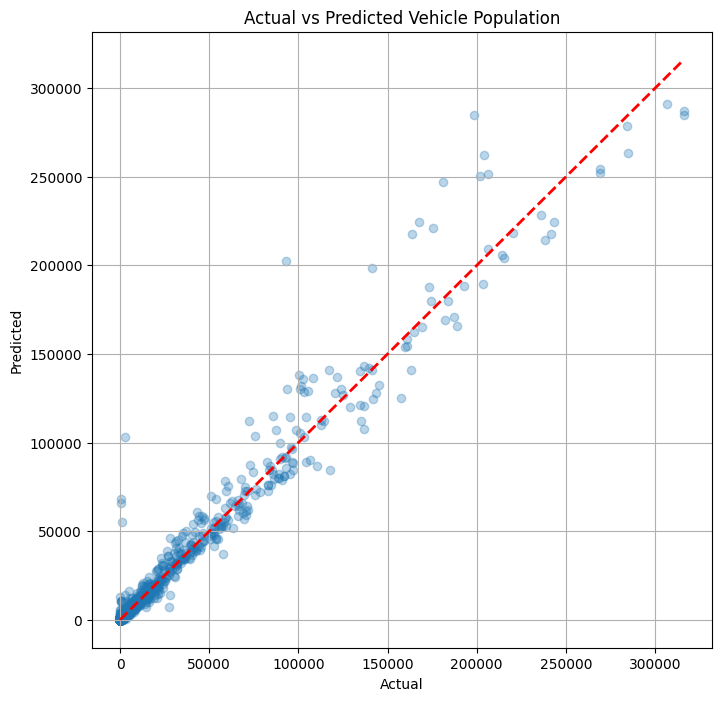

In [412]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Step 1: Generate predictions from base models
rf_preds = random_forest_model.predict(X_test)
cb_preds = best_catboost_model.predict(X_test_cat)

# Step 2: Apply weighted averaging
rf_weight = 0.9 # Give more importance to Random Forest
cb_weight = 0.1  # Less weight to CatBoost

stacked_pred_2 = (rf_weight * rf_preds) + (cb_weight * cb_preds)

# Step 3: Ensure non-negative predictions
stacked_pred_2 = np.maximum(stacked_pred_2, 0)

# Step 4: Evaluate performance
rmse_stacked = np.sqrt(mean_squared_error(y_test, stacked_pred_2))
mae_stacked = mean_absolute_error(y_test, stacked_pred_2)
r2_stacked = r2_score(y_test, stacked_pred_2)

# Print evaluation metrics
print("*" * 50)
print("TEST SET (Weighted Averaging)")
print(f"Mean Absolute Error (MAE): {mae_stacked}")
print(f"Root Mean Squared Error (RMSE): {rmse_stacked}")
print(f"R-squared (R2): {r2_stacked}")

# Step 5: Show predictions
results_df = pd.DataFrame({'y_test': y_test, 'y_pred': stacked_pred_2})
print(results_df)
# Plot the actual vs predicted values
plt.figure(figsize=(8, 8))
plt.scatter(y_test, stacked_pred_2, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Vehicle Population')
plt.grid(True)
plt.show()
results_df.to_csv("/Users/trongphan/Downloads/Rice_Datathon/rice-datathon-2025/Assign_weight.csv", index=False)


#### 3. 2 RF + 1 Catboost -> LR

In [413]:
# Train second Random Forest model with optimized parameters
rf_params = {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
random_forest_model_2 = RandomForestRegressor(random_state=28, **rf_params)
random_forest_model_2.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, max_features='sqrt', min_samples_split=5,
                      n_estimators=200, random_state=28)

**************************************************
TEST SET (Weighted Averaging with Two RF Models)
Mean Absolute Error (MAE): 579.4495044661954
Root Mean Squared Error (RMSE): 3753.2888703175677
R-squared (R2): 0.9628249534074114
      y_test         y_pred
0     316065  290055.864750
1     315986  298018.588081
2     306487  291363.597861
3     284754  265989.965513
4     284153  279386.936681
...      ...            ...
7541       1       0.000000
7542       1       0.000000
7543       1       0.000000
7544       1       0.000000
7545       1       0.000000

[7546 rows x 2 columns]


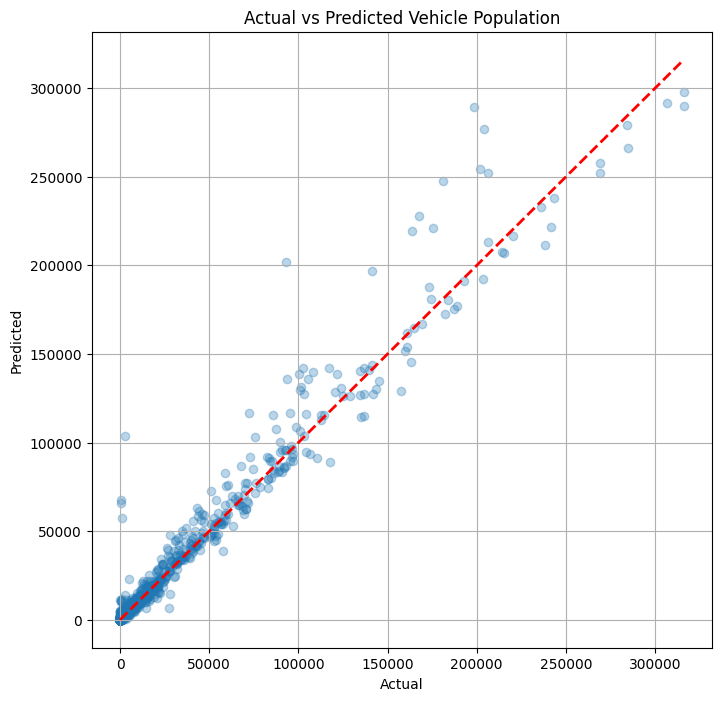

In [414]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Step 1: Generate predictions from base models
rf_preds_1 = random_forest_model.predict(X_train)  # First Random Forest model
rf_preds_2 = random_forest_model_2.predict(X_train)  # Second Random Forest model (with different hyperparameters)
cb_preds = best_catboost_model.predict(X_train_cat)  # CatBoost predictions
stacked_features = np.column_stack((rf_preds_1, rf_preds_2, cb_preds))

# Step 2: Train the meta-model (using RF predictions as the main guidance)
meta_model = LinearRegression()
meta_model.fit(stacked_features, y_train)

# Step 3: Predict using the meta-model
rf_preds_1_test = random_forest_model.predict(X_test)  # First Random Forest model
rf_preds_2_test = random_forest_model_2.predict(X_test)  # Second Random Forest model (with different hyperparameters)
cb_preds_test = best_catboost_model.predict(X_test_cat)  # CatBoost predictions
stacked_features_test = np.column_stack((rf_preds_1_test, rf_preds_2_test, cb_preds_test))
stacked_preds_test = meta_model.predict(stacked_features_test)

# Step 4: Ensure non-negative predictions (since vehicle population can't be negative)
stacked_preds = np.maximum(stacked_preds_test, 0)
# Step 5: Evaluate performance
rmse_stacked = np.sqrt(mean_squared_error(y_test, stacked_preds_test))
mae_stacked = mean_absolute_error(y_test, stacked_preds_test)
r2_stacked = r2_score(y_test, stacked_preds_test)

# Print evaluation metrics
print("*" * 50)
print("TEST SET (Weighted Averaging with Two RF Models)")
print(f"Mean Absolute Error (MAE): {mae_stacked}")
print(f"Root Mean Squared Error (RMSE): {rmse_stacked}")
print(f"R-squared (R2): {r2_stacked}")

# Step 5: Show predictions
results_df = pd.DataFrame({'y_test': y_test, 'y_pred': stacked_preds})
print(results_df)
# Plot the actual vs predicted values
plt.figure(figsize=(8, 8))
plt.scatter(y_test, stacked_preds, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Vehicle Population')
plt.grid(True)
plt.show()
results_df.to_csv('/Users/trongphan/Downloads/Rice_Datathon/rice-datathon-2025/output/results.csv', index=False)

#### 4. Stack 2rf + 1cat -> rf

**************************************************
Model: Two RF Models ONLY
Mean Absolute Error (MAE): 559.9013827098557
Root Mean Squared Error (RMSE): 3719.927702326981
R-squared (R2): 0.9634828783554417
**************************************************
Model: Two RF Models + CatBoost
Mean Absolute Error (MAE): 563.7931687144245
Root Mean Squared Error (RMSE): 3736.972452002661
R-squared (R2): 0.9631474679782615
      y_test     y_pred
0     316065  279491.90
1     315986  294791.51
2     306487  288526.82
3     284754  257626.26
4     284153  276024.33
...      ...        ...
7541       1       1.58
7542       1       2.75
7543       1       2.57
7544       1       3.35
7545       1       2.82

[7546 rows x 2 columns]


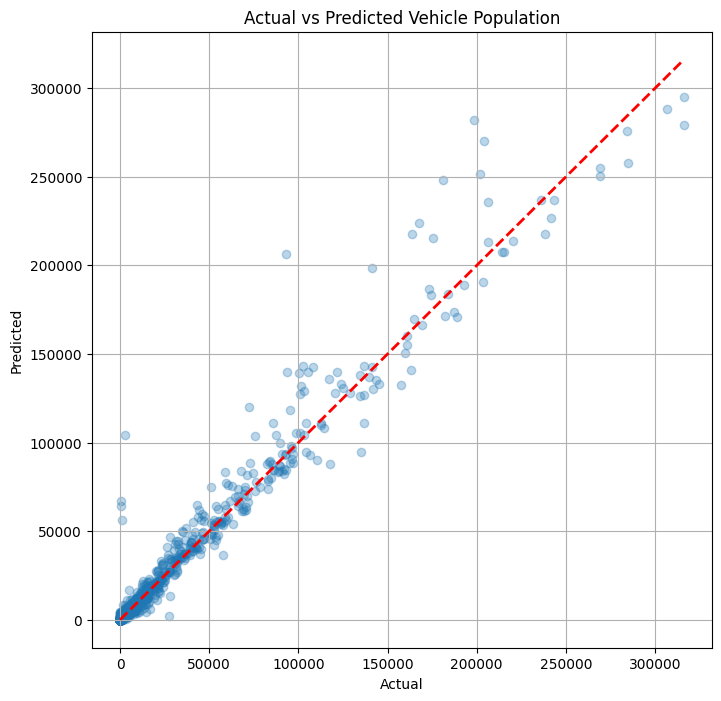

In [415]:
# Step 1: Train the base models
# Step 2: Generate predictions on the train set
rf_preds_1 = random_forest_model.predict(X_train)  # First Random Forest model
rf_preds_2 = random_forest_model_2.predict(X_train)  # Second Random Forest model (with different hyperparameters)
cb_preds = best_catboost_model.predict(X_train_cat)  # CatBoost predictions

# Step 3: Stack the predictions from the base models

"""
First, I try with 2 RF only. The result is good, with ~3726 RMSE. Then, I try with 3 models: 2 RF and 1 CatBoost. The result is better.
* Reason: The CatBoost model provides additional information that can help improve the predictions and can detect extreme case (the vehicle population is very small, which is <10).
"""
stacked_features_rf_only = np.column_stack((rf_preds_1, cb_preds)) 
stacked_features_rf_cb = np.column_stack((rf_preds_1, rf_preds_2, cb_preds))

# Step 4: Train the meta-model (Random Forest)
# RF only
meta_rf_only = RandomForestRegressor(random_state=28)
meta_rf_only.fit(stacked_features_rf_only, y_train)
# RF + CatBoost
meta_rf_cb = RandomForestRegressor(random_state=28)
meta_rf_cb.fit(stacked_features_rf_cb, y_train)

# Step 5: Make final predictions
rf_preds_1_test = random_forest_model.predict(X_test)  # First Random Forest model
rf_preds_2_test = random_forest_model_2.predict(X_test)  # Second Random Forest model (with different hyperparameters)
cb_preds_test = best_catboost_model.predict(X_test_cat)  # CatBoost predictions

stacked_features_rf_only_test = np.column_stack((rf_preds_1_test, rf_preds_2_test)) 
stacked_features_rf_cb_test = np.column_stack((rf_preds_1_test, rf_preds_2_test, cb_preds_test))

stacked_preds_rf_only_test = meta_rf_only.predict(stacked_features_rf_only_test)
stacked_preds_rf_cb_test = meta_rf_cb.predict(stacked_features_rf_cb_test)

# Step 6: Evaluate performance
# RF only
mae_stacked_rf_only = mean_absolute_error(y_test, stacked_preds_rf_only_test)
rmse_stacked_rf_only = np.sqrt(mean_squared_error(y_test, stacked_preds_rf_only_test))
r2_stacked_rf_only = r2_score(y_test, stacked_preds_rf_only_test)

# RF + CatBoost
mae_stacked_rf_cb = mean_absolute_error(y_test, stacked_preds_rf_cb_test)
rmse_stacked_rf_cb = np.sqrt(mean_squared_error(y_test, stacked_preds_rf_cb_test))
r2_stacked_rf_cb = r2_score(y_test, stacked_preds_rf_cb_test)

# Print evaluation metrics
print("*" * 50)
print("Model: Two RF Models ONLY")
print(f"Mean Absolute Error (MAE): {mae_stacked_rf_only}")
print(f"Root Mean Squared Error (RMSE): {rmse_stacked_rf_only}")
print(f"R-squared (R2): {r2_stacked_rf_only}")

print("*" * 50)
print("Model: Two RF Models + CatBoost")
print(f"Mean Absolute Error (MAE): {mae_stacked_rf_cb}")
print(f"Root Mean Squared Error (RMSE): {rmse_stacked_rf_cb}")
print(f"R-squared (R2): {r2_stacked_rf_cb}")


results_df = pd.DataFrame({'y_test': y_test, 'y_pred': stacked_preds_rf_cb_test})
print(results_df)
# Plot the actual vs predicted values
plt.figure(figsize=(8, 8))
plt.scatter(y_test, stacked_preds_rf_cb_test, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Vehicle Population')
plt.grid(True)
plt.show()
results_df.to_csv('/Users/trongphan/Downloads/Rice_Datathon/rice-datathon-2025/output/results.csv', index=False)

df_test_final = pd.read_excel('/Users/trongphan/Downloads/Rice_Datathon/rice-datathon-2025/data/scoring & submission format.xlsx')
df_test_final['Vehicle Population Predicted'] = stacked_preds_rf_cb_test
df_test_final.to_csv('/Users/trongphan/Downloads/Rice_Datathon/rice-datathon-2025/output/results.csv', index=False)

**LET FUCKING GO!!!!!!!**

#### 4. Log trans